# Analysis of the daily temperatures problems algorithms

This notebook serves the purporse of the investigation of an algorithm that I wrote to solve the daily temperature problem. Teh notebook doesn't quite fit in this repository, but I didn't want to put it in a new one, so I added it here for now  

In [ ]:
import numpy as np
import time
from typing import List,Tuple  

class Solution:
    def dailyTemperatures(self, temperatures: List[int]) -> List[int]:
        res = [0] * len(temperatures)
        stack: List[Tuple[int, int]] = [] 

        for i, t in enumerate(temperatures):
            while stack and t > stack[-1][0]:
                stackT, stackInd = stack.pop() # type: ignore
                res[stackInd] = i - stackInd
            stack.append((t, i))
        return res

    def myDailyTemperatures(self, temperatures: List[int]) -> List[int]:
        stack: List[Tuple[int,int,int]] = []

        for i in range(-1, -len(temperatures) - 1, -1):
            if i == -1:
                stack.append((len(temperatures) + i, 0, abs(i) - 1))
                continue
            else:
                top = stack.pop()
                if temperatures[i] > temperatures[top[0]]:
                    if top[1] == 0:
                        stack.append(top)
                        stack.append((len(temperatures) + i, 0, 0))
                        continue
                    curr = top
                    for _ in range(len(stack) + 1):
                        if temperatures[i] > temperatures[curr[0]]:
                            if curr[1] == 0:
                                stack.append(top)
                                stack.append((len(temperatures) + i, 0, 0))
                                break
                            curr = stack[curr[2]]
                        elif temperatures[i] == temperatures[curr[0]]:
                            offset: int = curr[0] - (len(temperatures) + i)
                            days_till = curr[1] + offset if curr[1] != 0 else 0
                            stack.append(top)
                            stack.append((len(temperatures) + i, days_till, top[2]))
                            break
                        else:
                            offset: int = curr[0] - (len(temperatures) + i)
                            stack.append(top)
                            stack.append((len(temperatures) + i, offset, abs(i) - 1 - offset))
                            break
                elif temperatures[i] == temperatures[top[0]]:
                    offset: int = top[0] - (len(temperatures) + i)
                    days_till = top[1] + offset if top[1] != 0 else 0
                    stack.append(top)
                    stack.append((len(temperatures) + i, days_till, top[2]))
                else:
                    stack.append(top)
                    stack.append((len(temperatures) + i, 1, abs(i) - 2))

        reversed_stack = reversed(stack)
        daily_list = [entry[1] for entry in reversed_stack]
        return daily_list

    def bruteForceDailyTemperatures(self, temperatures: List[int]) -> List[int]:
        n = len(temperatures)
        res: list[int] = []

        for i in range(n):
            count = 1
            j = i + 1
            while j < n:
                if temperatures[j] > temperatures[i]:
                    break
                j += 1
                count += 1
            count = 0 if j == n else count
            res.append(count)
        return res

    def dpDailyTemperatures(self, temperatures: List[int]) -> List[int]:
        n = len(temperatures)
        res = [0] * n

        for i in range(n - 2, -1, -1):
            j = i + 1
            while j < n and temperatures[j] <= temperatures[i]:
                if res[j] == 0:
                    j = n
                    break
                j += res[j]

            if j < n:
                res[i] = j - i
        return res

In [ ]:
from functools import wraps
from typing import Callable, List, Tuple, Any, Optional

# Decorator for timing and validating algorithms
def performance_tester(benchmark_func: Optional[Callable[[Any], Any]]):
    """
    Decorator to measure execution time and optionally validate output against a benchmark function.

    Args:
        benchmark_func (Optional[Callable]): Reference function for validation. If None, only timing is performed.

    Returns:
        Callable: Decorator that wraps the target function.
    """
    def decorator(func: Callable[[Any], Any]):
        @wraps(func)
        def wrapper(*args:Tuple[Any, List[int]], **kwargs:Any):
            """
            Wrapper to time the execution and validate output.

            Args:
                *args: Positional arguments for the target function.
                **kwargs: Keyword arguments for the target function.

            Returns:
                Tuple[result, execution_time]: Output of the function and time taken.
            """
            t_0 = time.perf_counter()
            result = func(*args, **kwargs)
            t_1 = time.perf_counter()
            execution_time = t_1 - t_0
            # Validate against the benchmark function if provided
            if benchmark_func is not None:
                # benchmark function returns result, execution_time
                benchmark_result = benchmark_func(*args, **kwargs)[0]
                if result != benchmark_result:
                    raise ValueError(f"The algorithm {func.__name__} returned an unexpected value. \
                                     Args: {args} \
                                     Kwargs: {kwargs} \
                                     Expected: {benchmark_result} \n Output: {result}  \
                                     ")
            return result, execution_time
        return wrapper
    return decorator

def test_performance(algorithms: List[Callable[[Any], Tuple[List[int], float]]], num_tests: int = 100) -> Tuple[List[np.ndarray], np.ndarray]:
    """
    Benchmark multiple algorithms on randomly generated temperature arrays of 1<=length<=10000
    and 30<=temperatures<=100 sampled from a uniform distribution.

    Args:
        algorithms (List[Callable]): List of decorated algorithm functions.
        num_tests (int): Number of random test cases to run.

    Returns:
        Tuple[List[np.ndarray], np.ndarray]: List of test inputs and array of execution times.
    """
    rng = np.random.default_rng()
    test_inputs: List[np.ndarray] = []
    execution_times: List[List[float]] = [[] for _ in algorithms]

    for _ in range(num_tests):
        array_length = int(rng.random() * 10000)
        # to fit with leetcode constraints of temperatures between 30 and 100 
        temperature_array = rng.choice(71, size=array_length) + 30
        test_inputs.append(temperature_array)

        # Apply each algorithm and record execution time
        for index, algorithm in enumerate(algorithms):
            _, exec_time = algorithm(temperature_array)
            execution_times[index].append(exec_time)

    # Can't cast input to np.ndarray because of different dimensions of inner objects
    return test_inputs, np.array(execution_times)

def custom_test_case(algorithms: List[Callable[[Any], Tuple[List[int], float]]]) -> np.ndarray:
    """
    Run a custom test case on all algorithms using a specific temperature array.

    Args:
        algorithms (List[Callable]): List of decorated algorithm functions.

    Returns:
        np.ndarray: Array of execution times for the custom test case.
    """
    execution_times: List[List[float]] = [[] for _ in algorithms]
    # Array from 9999-5001 + 0-5000, 10k
    temperature_array = np.concatenate([np.arange(start=9999,stop=5000,step=-1),np.arange(5001)])
    for index,algorithm in enumerate(algorithms):
        _, exec_time = algorithm(temperature_array)
        execution_times[index].append(exec_time)
    
    return np.array(execution_times)

# Applying the decorator to the algorithms
solution_obj = Solution()

# Benchmark function, monotonic stack algorithm
@performance_tester(None)
def benchmark_func(temperatures: Any) -> List[int]:
    """
    Benchmark solution for dailyTemperatures using the optimal stack approach.

    Args:
        temperatures (list[int]): List of daily temperatures.

    Returns:
        list[int]: List of days to wait for a warmer temperature.
    """
    return solution_obj.dailyTemperatures(temperatures)

# DP algorithm
@performance_tester(benchmark_func)
def dp_func(temperatures: Any) -> List[int]:
    """
    DP solution for dailyTemperatures using the DP approach (optimal).

    Args:
        temperatures (list[int]): List of daily temperatures.

    Returns:
        list[int]: List of days to wait for a warmer temperature.
    """
    return solution_obj.dpDailyTemperatures(temperatures)

# Other algorithms
@performance_tester(benchmark_func)
def brute_force_func(temperatures: Any) -> List[int]:
    """
    Brute force solution for dailyTemperatures.

    Args:
        temperatures (list[int]): List of daily temperatures.

    Returns:
        list[int]: List of days to wait for a warmer temperature.
    """
    return solution_obj.bruteForceDailyTemperatures(temperatures)

@performance_tester(benchmark_func)
def my_func(temperatures: Any) -> List[int]:
    """
    Custom solution for dailyTemperatures using a reverse "stack" approach.

    Args:
        temperatures (list[int]): List of daily temperatures.

    Returns:
        list[int]: List of days to wait for a warmer temperature.
    """
    return solution_obj.myDailyTemperatures(temperatures)

# Run the test
performance_results = test_performance([benchmark_func, dp_func, my_func,brute_force_func])

In [14]:
# Run custom tests
custom_performance_results = custom_test_case([benchmark_func, dp_func, my_func,brute_force_func])

In [26]:
# Get the sort order by input length
sort_order = np.argsort([len(arr) for arr in performance_results[0]])

# Sort inputs
sorted_inputs = [performance_results[0][i] for i in sort_order]

# Sort times for each algorithm
sorted_times = [performance_results[1][alg_idx][sort_order] for alg_idx in range(performance_results[1].shape[0])]

lengths = [len(arr) for arr in sorted_inputs]

print(len(sorted_times))

4


100
113
253
489
672
673
796
849
884
990
1246
1336
1410
1891
1914
1927
2023
2075
2185
2239
2387
2515
2664
2782
2828
2864
3035
3083
3338
3441
3493
3506
3733
3756
3771
3819
3906
4081
4135
4189
4298
4312
4691
4881
4925
4931
5206
5314
5484
5638
5649
5768
5945
6012
6062
6078
6243
6268
6295
6313
6594
6662
6717
6739
6750
6838
6877
6945
7153
7300
7378
7499
7576
7612
7645
7653
7695
7876
7984
8204
8486
9013
9046
9070
9099
9124
9139
9142
9191
9229
9325
9414
9445
9521
9541
9593
9628
9649
9698
9764
9982


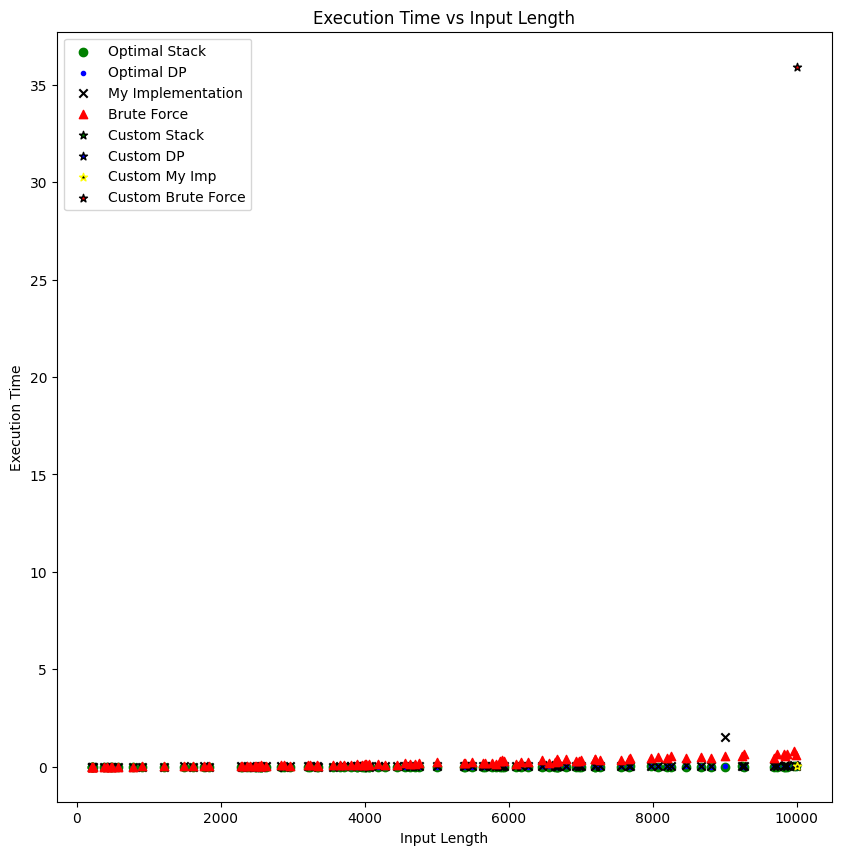

In [45]:
import matplotlib.pyplot as plt

# Plot times vs len of array
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(lengths, sorted_times[0], marker='o', color='g', label='Optimal Stack')
ax.scatter(lengths, sorted_times[1], marker='.', color='b', label='Optimal DP')
ax.scatter(lengths, sorted_times[2], marker='x', color='k', label='My Implementation')
ax.scatter(lengths, sorted_times[3], marker='^', color='r', label='Brute Force')

# Add custom test case results as large stars at input length 10000
custom_length = 10000
ax.scatter([custom_length], [custom_performance_results[0][0]], marker='*', color='g', label='Custom Stack', edgecolors='black')
ax.scatter([custom_length], [custom_performance_results[1][0]], marker='*', color='b', label='Custom DP', edgecolors='black')
ax.scatter([custom_length], [custom_performance_results[2][0]], marker='*', color='k', label='Custom My Imp', edgecolors='yellow')
ax.scatter([custom_length], [custom_performance_results[3][0]], marker='*', color='r', label='Custom Brute Force', edgecolors='black')

ax.set_xlabel("Input Length")
ax.set_ylabel("Execution Time")
ax.set_title("Execution Time vs Input Length")
ax.legend()
plt.show()

In [46]:
np.argmax(sorted_times[2])
print(sorted_inputs[90])

[81 95 41 ... 62 35 37]


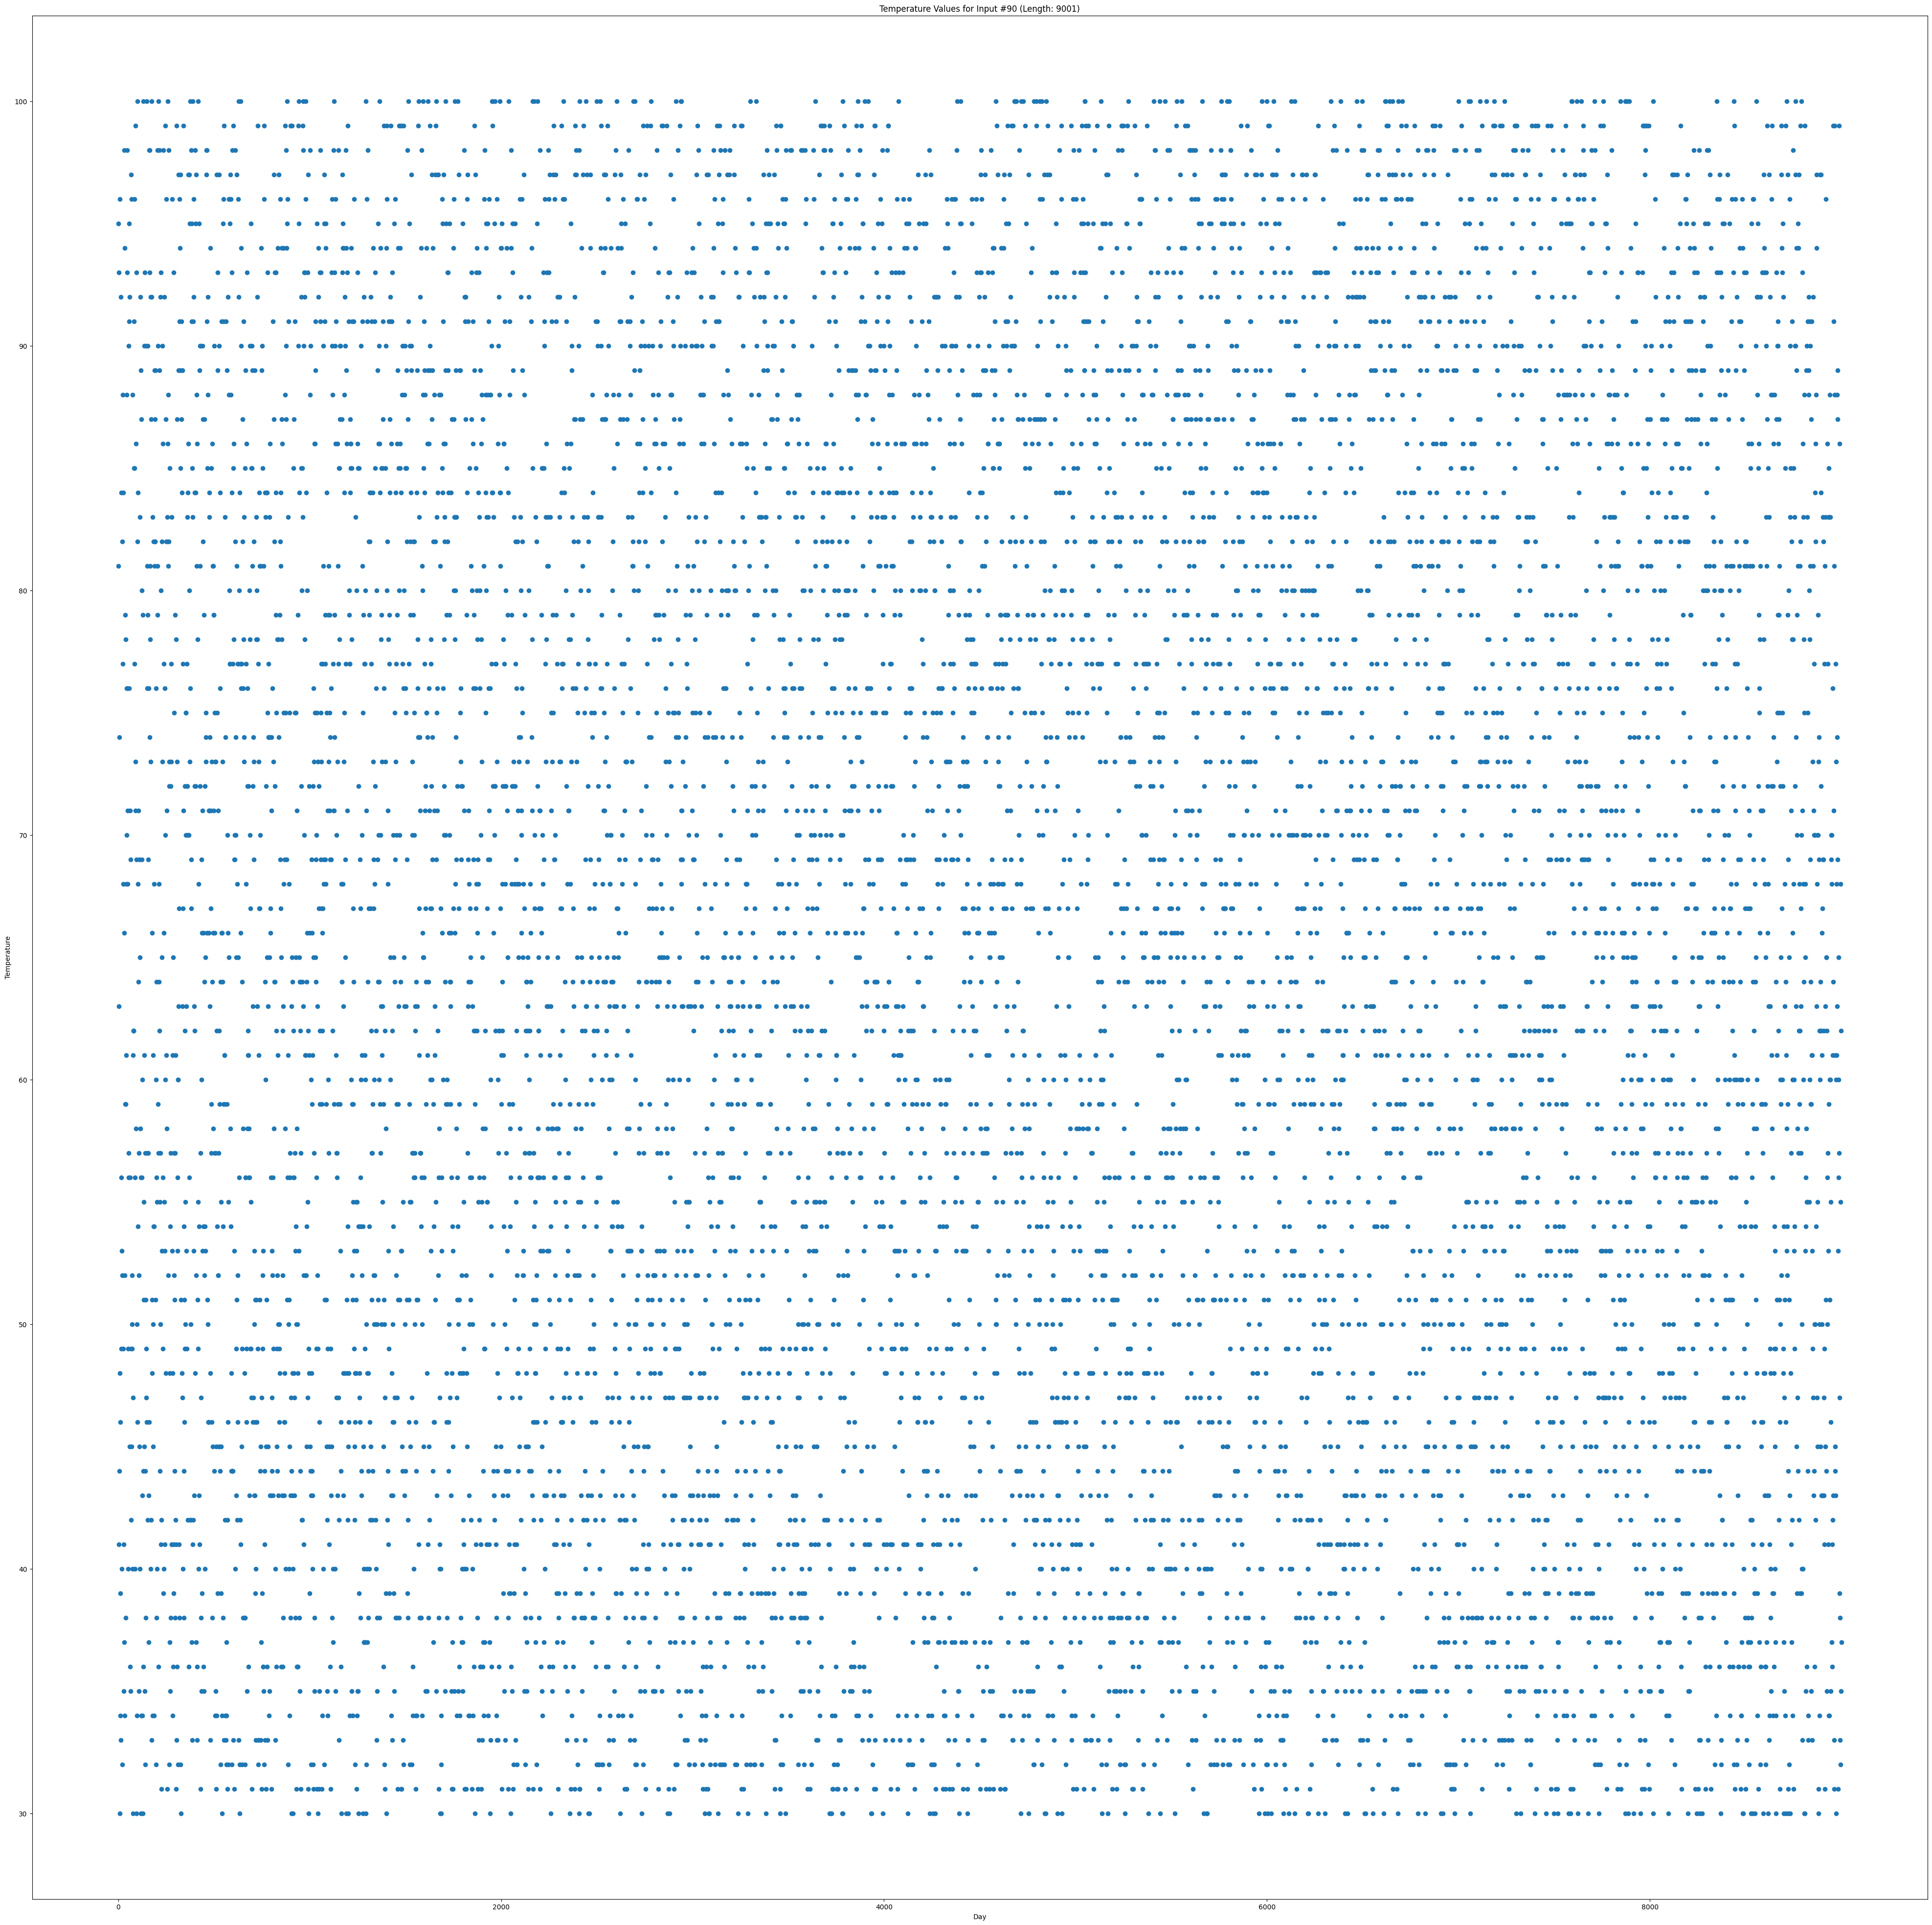

In [ ]:
# Scatter plot of temperature values for outlier
input_index = 90
input_array = sorted_inputs[input_index]
plt.figure(figsize=(50, 50))
plt.scatter(range(len(input_array)), input_array)
plt.title(f"Temperature Values for Input #{input_index} (Length: {len(input_array)})")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.show()